## Data Description

Here's the data description provided for this dataset. There is no data dictionary in order to avoid leaking user information.

### Transaction Dataframe

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R_) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

**Categorical Features**

- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

### Identity Dataframe

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)


**Categorical Features**

- DeviceType
- DeviceInfo
- id_12 - id_38

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re

In [3]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
start_time = time.time()

In [7]:
#path = "/content/drive/MyDrive/Colab_Notebooks/IEEE fraud detection/"
path = ""

In [8]:
df_train_id = pd.read_csv(path + "train_identity.csv")

In [9]:
df_train_tran = pd.read_csv(path + "train_transaction.csv")

In [10]:
#Let's display all the columns in the dataframe
pd.set_option('display.max_columns', None)

In [11]:
df_train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [12]:
df_train_tran.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [13]:
df_train_id.shape

(144233, 41)

In [14]:
df_train_tran.shape

(590540, 394)

The transactions dataset appears to be huge.

In [15]:
df_train_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [16]:
#Setting verbose and null_counts to True as info() won't display the details we need by default for such a large dataframe

df_train_tran.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 394 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int64  
 1   isFraud         590540 non-null  int64  
 2   TransactionDT   590540 non-null  int64  
 3   TransactionAmt  590540 non-null  float64
 4   ProductCD       590540 non-null  object 
 5   card1           590540 non-null  int64  
 6   card2           581607 non-null  float64
 7   card3           588975 non-null  float64
 8   card4           588963 non-null  object 
 9   card5           586281 non-null  float64
 10  card6           588969 non-null  object 
 11  addr1           524834 non-null  float64
 12  addr2           524834 non-null  float64
 13  dist1           238269 non-null  float64
 14  dist2           37627 non-null   float64
 15  P_emaildomain   496084 non-null  object 
 16  R_emaildomain   137291 non-null  object 
 17  C1       

As we expected, the transaction dataset is very large and takes up 1.7 GB. We can reduce the memory usage by converting 64-bit columns into 32-bit or 16-bit. Let's do this after merging the two dataframes.

### Merging the two dataframes

Let's merge the two dataframes on their identity column: TransactionID

In [17]:
#Checking the number of unique transaction IDs in the identity dataframe and comparing this to the number of rows in the df
print(df_train_id['TransactionID'].unique().shape[0])
print(df_train_id.shape[0])

144233
144233


In [18]:
#Doing the same for the transaction dataframe
print(df_train_tran['TransactionID'].unique().shape[0])
print(df_train_tran.shape[0])

590540
590540


The identity dataframe has fewer unique TransactionIDs than the transaction dataframe. Also, there are no repeated transaction IDs in either dataframe.

Since the transaction dataframe conains more than twice the number of rows that the identity dataframe has, let's retain those rows and add the columns of the identity dataframe wherever possible.

In [19]:
train_df = pd.merge(df_train_id, df_train_tran, on="TransactionID", how='right')

In [20]:
train_df.shape

(590540, 434)

The number of rows in 590540, the same number that we had in the transaction dataframe. This is a huge dataframe, as it has 434 columns and half a million rows.

In [21]:
#Deleting the initial dataframes

del df_train_id, df_train_tran

In [22]:
#Triggering garbage collection

gc.collect()

247

### Reducing Memory Usage

Let's check the memory usage of the merged train dataframe.

In [ ]:
print("Train set: {:4.2f} Mb".format(train_df.memory_usage().sum() / 1024**2))

Let's see if the memory usage of this dataframe can be reduced.

In [23]:
#Defining a function to convert columns to smaller sizes

def float_int_memory_reducer(df, verbose=True):
    
    reduce_datatypes = ['int16', 'int32', 'int64', 'float32', 'float64']        #We'll try to reduce columns with these data types.
    starting_memory = df.memory_usage().sum() / 1024**2
    
    for column in df.columns:
        
        column_type = df[column].dtypes
        
        if column_type in reduce_datatypes:
            
            col_min = df[column].min()
            col_max = df[column].max()
            
            if str(column_type)[:3] == 'int':
                
                # We can use np.iinfo().max to find the maximum size for integer data types
                
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                    
            else:
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                    df[column] = df[column].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                    
    ending_memory = df.memory_usage().sum() / 1024**2
    
    if verbose: 
        print('Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(ending_memory, 100 * (starting_memory - ending_memory) / starting_memory))
    
    return df

In [24]:
start_process_time = time.time()

In [25]:
train_df = float_int_memory_reducer(train_df)
print('Training set dimensions:', train_df.shape)

Memory usage decreased to 650.48 Mb (66.8% reduction)
Training set dimensions: (590540, 434)


In [26]:
elapsed_time = time.time() - start_process_time
print(elapsed_time/60)

1.3907506148020425


In [27]:
#Triggering garbage collection

gc.collect()

40

#### Repeating these steps (reading, merging, and reducing memory usage) for the test dataset

In [28]:
#Reading the train data from the csv files

df_test_id = pd.read_csv(path + "test_identity.csv")
df_test_tran = pd.read_csv(path + "test_transaction.csv")

print(df_test_id.shape)
print(df_test_tran.shape)

(141907, 41)
(506691, 393)


In [29]:
#Merging the two dataframes
test_df = pd.merge(df_test_id, df_test_tran, on="TransactionID", how='right')
test_df.shape

(506691, 433)

In [30]:
#Deleting the old dataframes

del df_test_id, df_test_tran

In [31]:
#Reducing the memory used by the combined dataframe

test_df = float_int_memory_reducer(test_df)
print('Test set dimensions: ', test_df.shape)

Memory usage decreased to 565.37 Mb (66.3% reduction)
Test set dimensions:  (506691, 433)


In [32]:
#Triggering garbage collection

gc.collect()

20

## Handling Missing Values

In [33]:
train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 434 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int32  
 1   id_01           144233 non-null  float16
 2   id_02           140872 non-null  float32
 3   id_03           66324 non-null   float16
 4   id_04           66324 non-null   float16
 5   id_05           136865 non-null  float16
 6   id_06           136865 non-null  float16
 7   id_07           5155 non-null    float16
 8   id_08           5155 non-null    float16
 9   id_09           74926 non-null   float16
 10  id_10           74926 non-null   float16
 11  id_11           140978 non-null  float16
 12  id_12           144233 non-null  object 
 13  id_13           127320 non-null  float16
 14  id_14           80044 non-null   float16
 15  id_15           140985 non-null  object 
 16  id_16           129340 non-null  object 
 17  id_17    

As we can see, there a lot of missing values. Let's check the percentage of missing values in each column.

In [34]:
#Setting the maximum number of rows to display as 500
pd.set_option('display.max_rows', 500)

In [35]:
#Checking the percentage of missing values in each column

(train_df.isnull().sum()*100/train_df.shape[0]).sort_values(ascending=False)

id_24             99.196159
id_25             99.130965
id_07             99.127070
id_08             99.127070
id_21             99.126393
id_26             99.125715
id_27             99.124699
id_23             99.124699
id_22             99.124699
dist2             93.628374
D7                93.409930
id_18             92.360721
D13               89.509263
D14               89.469469
D12               89.041047
id_04             88.768923
id_03             88.768923
D6                87.606767
id_33             87.589494
id_10             87.312290
D8                87.312290
id_09             87.312290
D9                87.312290
id_30             86.865411
id_32             86.861855
id_34             86.824771
id_14             86.445626
V157              86.123717
V162              86.123717
V139              86.123717
V138              86.123717
V155              86.123717
V149              86.123717
V141              86.123717
V148              86.123717
V147              86

In [36]:
#Storing the column names and their percentage of missing values in a new dataframe

missing_values_df = pd.DataFrame(train_df.isnull().sum()*100/train_df.shape[0])

In [37]:
missing_values_df.head()

,0
TransactionID,0.000000
id_01,75.576083
id_02,76.145223
id_03,88.768923
id_04,88.768923


This dataframe needs to be formatted.

In [38]:
#Storing the column names in a different column
missing_values_df['Column_name'] = missing_values_df.index

In [39]:
#Renaming the column 0
missing_values_df.rename(columns = {0 : 'Percentage_missing'}, inplace=True)

In [40]:
#Resetting the index of the dataframe to have numerical values
missing_values_df = missing_values_df.reset_index(drop=True)

In [41]:
missing_values_df.head()

,Percentage_missing,Column_name
0,0.000000,TransactionID
1,75.576083,id_01
2,76.145223,id_02
3,88.768923,id_03
4,88.768923,id_04


In [42]:
#Rearranging the columns in the dataframe

missing_values_df = missing_values_df[['Column_name', 'Percentage_missing']]
missing_values_df.head()

,Column_name,Percentage_missing
0,TransactionID,0.000000
1,id_01,75.576083
2,id_02,76.145223
3,id_03,88.768923
4,id_04,88.768923


In [43]:
#Sorting the column names by their percentage of missing values

missing_values_df.sort_values(by='Percentage_missing', ascending=False)

,Column_name,Percentage_missing
24,id_24,99.196159
25,id_25,99.130965
7,id_07,99.127070
8,id_08,99.127070
21,id_21,99.126393
26,id_26,99.125715
27,id_27,99.124699
23,id_23,99.124699
22,id_22,99.124699
54,dist2,93.628374


There's a jump from 75.58% missing to 59.65% missing values, and a similar jump from 44.52% to 28.68%.

In [44]:
#Checking the number of columns that have 75% missing values or more
missing_values_df[missing_values_df['Percentage_missing']>= 75].shape[0]

208

In [45]:
#Checking the number of columns that have 40% missing values or more
missing_values_df[missing_values_df['Percentage_missing']>= 50].shape[0]

214

In [46]:
#Checking the number of columns that have 20% missing values or more
missing_values_df[missing_values_df['Percentage_missing']>= 20].shape[0]

252

In [47]:
#A reminder of the dimensions of the dataframe
train_df.shape

(590540, 434)

Since the difference between the number of columns that have 75% (or more) values missing and 20% (or more) values missing is 252 - 208 = 44 columns, let's go ahead and drop columns that have 20% missing values or more. This will mean dropping 252 columns. 

Note: this is one way in which data preparation differs for these models when compared to LGBM; I'm dropping more columns as we will have to use mean imputation/MICE imputation for these models.

In [48]:
#Removing the columns that have 40% missing values or more from this list
missing_values_df = missing_values_df[missing_values_df['Percentage_missing'] < 20]

In [49]:
#Sorting the column names by their percentage of missing values

missing_values_df.sort_values(by='Percentage_missing', ascending=False)

,Column_name,Percentage_missing
55,P_emaildomain,15.994852
184,V90,15.098723
170,V76,15.098723
172,V78,15.098723
173,V79,15.098723
174,V80,15.098723
175,V81,15.098723
176,V82,15.098723
177,V83,15.098723
178,V84,15.098723


In [50]:
#Storing the names of the columns to be retained in a list

cols_to_retain = missing_values_df['Column_name'].tolist()

In [51]:
#Making a note of the columns that are being dropped (to make the same changes to the training set)
dropped_columns = list(set(train_df.columns) - set(cols_to_retain))

In [52]:
#Checking the number of columns that we're planning to drop

print(train_df.shape)
print(train_df[cols_to_retain].shape)

(590540, 434)
(590540, 182)


Dropping the columns that have 20% (or more) null values (i.e., dropping 252 columns)

In [53]:
train_df = train_df[cols_to_retain]
train_df.shape

(590540, 182)

We cannot drop any rows, as we need to provide a probability of fraud for all the rows of the test set.

In [54]:
#Triggering garbage collection

gc.collect()

60

In [55]:
#Let's drop the TransactionID column, as that adds no value

train_df.drop(['TransactionID'], axis=1, inplace=True)

Since the TransactionID and probability of fraud are the two columns that need to be submitted, this column shouldn't be directly dropped from the test set.

In [56]:
train_df.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,13.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,315.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,84.0,111.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,gmail.com,1.0,1.0,0.0,0.0,0.0

#### Dropping columns in the test set

In [57]:
#Taking a look at the list of dropped columns

print(dropped_columns)

['id_03', 'M6', 'V138', 'V263', 'id_06', 'V227', 'V226', 'V217', 'V47', 'V186', 'id_21', 'V277', 'id_01', 'V231', 'V41', 'V229', 'V257', 'V328', 'V197', 'R_emaildomain', 'V49', 'V37', 'V216', 'V236', 'id_25', 'V274', 'V147', 'V200', 'id_13', 'DeviceType', 'M7', 'V151', 'V246', 'V140', 'V243', 'V204', 'V334', 'V172', 'id_12', 'V153', 'V271', 'V144', 'V260', 'id_34', 'V331', 'V221', 'id_28', 'V180', 'D3', 'id_09', 'V154', 'id_15', 'V161', 'V174', 'V207', 'V275', 'V222', 'id_02', 'id_20', 'V190', 'M3', 'V230', 'V11', 'id_04', 'V165', 'V324', 'V252', 'V219', 'V329', 'id_30', 'V4', 'V178', 'id_22', 'V253', 'V141', 'id_32', 'V220', 'id_17', 'V205', 'V167', 'V211', 'V39', 'D5', 'V176', 'V51', 'V338', 'V43', 'V160', 'V9', 'V269', 'M4', 'V179', 'id_38', 'V241', 'V223', 'V244', 'D12', 'V245', 'V323', 'V255', 'V225', 'V218', 'V261', 'V191', 'V234', 'id_07', 'V251', 'V183', 'D11', 'id_05', 'V239', 'V198', 'id_26', 'id_11', 'V232', 'V265', 'V254', 'V45', 'V40', 'V259', 'V1', 'V146', 'V157', 'id_19'

In [58]:
#Taking a look at the columns in the test set
test_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Data columns (total 433 columns):
 #   Column          Dtype  
---  ------          -----  
 0   TransactionID   int32  
 1   id-01           float16
 2   id-02           float32
 3   id-03           float16
 4   id-04           float16
 5   id-05           float16
 6   id-06           float16
 7   id-07           float16
 8   id-08           float16
 9   id-09           float16
 10  id-10           float16
 11  id-11           float16
 12  id-12           object 
 13  id-13           float16
 14  id-14           float16
 15  id-15           object 
 16  id-16           object 
 17  id-17           float16
 18  id-18           float16
 19  id-19           float16
 20  id-20           float16
 21  id-21           float16
 22  id-22           float16
 23  id-23           object 
 24  id-24           float16
 25  id-25           float16
 26  id-26           float16
 27  id-27           object 
 28  id-28        

Some of the column names are different in the test set. The id columns are followed by hyphens instead of underscores.

In [59]:
#Changing underscores to hyphens in the list of dropped columns
dropped_columns = [re.sub("id_", "id-", str(i)) for i in dropped_columns]

In [60]:
#Comparing the number of columns in the dataframe and the number of columns that will be dropped
print(test_df.shape[1])
print(test_df[dropped_columns].shape[1])

433
252


In [61]:
#Dropping columns in the test set
cols_to_retain = set(list(test_df.columns)) - set(dropped_columns)
test_df = test_df[cols_to_retain]
test_df.shape

(506691, 181)

### Replacing null values in categorical columns with 'unknown'

In [62]:
#Creating a list of the categorical columns in the dataframe
categorical_columns = ['ProductCD', 'card4', 'card6', 'P_emaildomain']

In [63]:
#Replacing missing values with 'unknown' in categorical columns
train_df[categorical_columns] = train_df[categorical_columns].apply(lambda x: x.fillna('unknown'))

#### Replacing null values with 'unknown' for categorical columns in the test set

In [64]:
test_df[categorical_columns] = test_df[categorical_columns].apply(lambda x: x.fillna('unknown'))
test_df.head()

,V84,V65,V283,V85,V72,D15,V32,V309,V55,C8,V321,card3,V15,V134,V25,V54,V115,V311,V288,V12,V121,V87,V64,V132,V98,V123,card6,C9,V76,V60,V117,TransactionDT,V99,C5,V91,V113,V306,V294,V22,V31,V77,V106,V137,V82,V116,V285,card5,V112,V94,V53,C7,V305,V74,V130,V69,V109,V61,V20,V18,V317,V73,V296,V28,card2,V105,V128,C6,V302,V316,V293,V303,C14,V280,V21,V26,V281,V136,V315,V295,V124,V287,V129,V125,V318,V66,V299,V33,V29,V290,V118,V314,V304,V19,V71,V320,V279,V88,C10,V110,V97,V300,V111,addr2,V119,C11,V16,V135,V122,addr1,card4,V133,C1,V56,V102,V286,V108,V291,V24,V34,C2,V282,V319,TransactionID,V13,V297,P_emaildomain,D10,V70,V23,V30,C13,V68,TransactionAmt,card1,V27,V127,V284,V114,V308,V86,V83,V57,C3,V17,V312,V289,V78,V14,V62,C4,V63,V89,V96,V90,V58,V92,V100,V93,V95,V301,V298,V104,V79,V59,V103,V107,V67,V80,V131,C12,V120,V313,V81,V310,V101,ProductCD,D1,V307,V75,V292,V126
0,0.0,1.0,0.0,0.0,0.0,409.0,0.0,0.0000,1.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,1.0,0.0000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,debit,6.0,0.0,0.0,1.0,18403224,1.0,3.0,1.0,1.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,226.0,1.0,0.0,0.0,0.0,1.0,0.0,47.950001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.0,0.0,0.000000,4.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,1.0,0.0,0.0000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,87.0,1.0,5.0,0.0,0.0,1.0,170.0,visa,0.0,6.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,6.0,0.0,0.0,3663549,0.0,0.0,gmail.com,418.0,0.0,1.0,0.0,115.0,0.0,31.953125,10409,0.0,47.950001,0.0,1.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,1.0,1.0,0.0000,0.0,47.950001,0.0,W,419.0,47.950001,0.0,1.0,0.000000
1,0.0,1.0,0.0,0.0,0.0,634.0,0.0,0.0000,1.0,0.0,0.0,150.0,0.0,0.0,1.0,0.0,1.0,0.0000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,debit,2.0,1.0,0.0,1.0,18403263,4.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,4.0,226.0,1.0,0.0,0.0,0.0,1.0,0.0,280.000000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,111.0,0.0,77.000000,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0000,0.0,1.0,1.0,0.0000,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,87.0,1.0,1.0,0.0,0.0,1.0,299.0,visa,0.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,3663550,1.0,0.0,aol.com,231.0,0.0,1.0,0.0,12.0,0.0,49.000000,4272,0.0,280.000000,0.0,1.0,77.000000,1.0,1.0,0.0,0.0,0.0,77.000000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,77.000000,1.0,1.0,0.0000,0.0,280.000000,0.0,W,149.0,280.000000,1.0,1.0,0.000000
2,0.0,1.0,0.0,0.0,0.0,97.0,0.0,0.0000,1.0,0.0,0.0,150.0,0.0,0.0,1.0,0.0,1.0,0.0000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,debit,4.0,2.0,0.0,1.0,18403310,3.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,4.0,226.0,1.0,0.0,0.0,0.0,1.0,0.0,705.000000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,574.0,2.0,0.000000,5.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,263.0,0.0000,0.0,1.0,0.0,0.0000,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.000,0.0,1.0,0.0,263.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,87.0,1.0,2.0,0.0,0.0,1.0,472.0,visa,0.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,3663551,1.0,0.0,hotmail.com,136.0,0.0,2.0,0.0,22.0,0.0,171.000000,4476,0.0,968.000000,0.0,1.0,0.000000,1.0,2.0,0.0,0.0,0.0,0.000000,0.0,2.0,1.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.0,1.0,0.0000,0.0,1058.000000,0.0,W,137.0,1321.000000,1.0,1.0,0.000000
3,0.0,1.0,1.0,0.0,0.0,242.0,0.0,0.0000,1.0,0.0,0.0,150.0,0.0,0.0,1.0,1.0,1.0,0.0000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,debit,2.0,1.0,0.0,1.0,18403310,0.0,1.0,1.0,1.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,166.0,1.0,0.0,1.0,0.0,1.0,0.0,0.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,360.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,282.5000,0.0,1.0,0.0,0.0000,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,282.500,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,87.0,1.0,2.0,0.0,0.0,1.0,205.0,visa,0.0,5.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,3663552,1.0,0.0,gmail.com,242.0,1.0,1.0,1.0,7.0,0.0,285.000000,10989,0.

### Imputing missing values

Let's impute missing values in two ways: mean imputation and MICE (Multiple Imputation by Chained Equations) imputation

#### Median and Mode Imputation

Let's use median imputation (mode for categorical features) for columns that contain less than 2% missing data. That way we avoid over-emphasizing the columns' median.

In [65]:
median_impute_cols = (missing_values_df['Column_name'][(missing_values_df['Percentage_missing'] > 0) & (missing_values_df['Percentage_missing'] <= 2)]).tolist()

In [66]:
len(median_impute_cols)

92

In [67]:
train_df[median_impute_cols].head()

,card2,card3,card4,card5,card6,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,NaN,150.0,discover,142.0,credit,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,404.0,150.0,mastercard,102.0,credit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,490.0,150.0,visa,166.0,debit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,567.0,150.0,mastercard,117.0,debit,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,514.0,150.0,mastercard,102.0,credit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's include categorical columns with more than 10% missing values (ProductCD and P_emaildomain) in the list for mode imputation, as MICE imputation cannot be used for categorical columns.

In [68]:
mode_impute_cols = ['card4', 'card6', 'ProductCD', 'P_emaildomain']
median_impute_cols.remove('card4')
median_impute_cols.remove('card6')

In [69]:
#Storing the median of columns, so that they can be used for imputation in the test set
medians_of_cols = train_df[median_impute_cols].median()

In [70]:
#Performing mean imputation
train_df[median_impute_cols] = train_df[median_impute_cols].apply(lambda x: x.fillna(x.median()))

In [71]:
#Storing the mode of categorical columns, so that they can be used for imputation in the test set
modes_of_cols = train_df[mode_impute_cols].mode()

In [72]:
#Performing mode imputation
train_df[mode_impute_cols] = train_df[mode_impute_cols].apply(lambda x: x.fillna(x.mode()))

In [73]:
train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 181 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   isFraud         590540 non-null  int8   
 1   TransactionDT   590540 non-null  int32  
 2   TransactionAmt  590540 non-null  float16
 3   ProductCD       590540 non-null  object 
 4   card1           590540 non-null  int16  
 5   card2           590540 non-null  float16
 6   card3           590540 non-null  float16
 7   card4           590540 non-null  object 
 8   card5           590540 non-null  float16
 9   card6           590540 non-null  object 
 10  addr1           524834 non-null  float16
 11  addr2           524834 non-null  float16
 12  P_emaildomain   590540 non-null  object 
 13  C1              590540 non-null  float16
 14  C2              590540 non-null  float16
 15  C3              590540 non-null  float16
 16  C4              590540 non-null  float16
 17  C5       

All of the columns with null values are float-type columns.

#### MICE (Multiple Imputation by Chained Equations) Imputation

In [74]:
#Making a backup of the dataframe

train_df_backup = train_df.copy()

In [75]:
#Selecting only the int and float-type columns and forming a new dataframe
train_df_not_string = train_df.select_dtypes(include=['int8', 'int16', 'int32', 'int64','float16', 'float32', 'float64'])

#Dropping the isFraud column as that is not present in the test set (and we're using the same imputer object to transform both datasets)
train_df_not_string.drop(['isFraud'], axis=1, inplace=True)

In [76]:
start_process_time = time.time()

#Instantiating the IterativeImputer class
imputer = IterativeImputer(skip_complete=True)
imputer.fit(train_df_not_string)

#Performing imputations
train_df_imputed = imputer.transform(train_df_not_string)

In [77]:
#Checking the time taken for this process
end_time = time.time() - start_process_time
print(end_time/60)

10.090484674771627


In [78]:
#Casting the numpy array train_df_imputed (IterativeImputer outputs a numpy array) as a pandas dataframe

train_df_not_string = pd.DataFrame(train_df_imputed, columns = train_df_not_string.columns)

In [79]:
#Making sure that there are no missing values in this dataframe

(train_df_not_string.isnull().sum()*100/train_df_not_string.shape[0]).sort_values(ascending=False)

V321              0.0
V320              0.0
V68               0.0
V67               0.0
V66               0.0
V65               0.0
V64               0.0
V63               0.0
V62               0.0
V61               0.0
V60               0.0
V59               0.0
V58               0.0
V57               0.0
V56               0.0
V55               0.0
V54               0.0
V53               0.0
V34               0.0
V33               0.0
V32               0.0
V69               0.0
V70               0.0
V71               0.0
V82               0.0
V90               0.0
V89               0.0
V88               0.0
V87               0.0
V86               0.0
V85               0.0
V84               0.0
V83               0.0
V81               0.0
V72               0.0
V80               0.0
V79               0.0
V78               0.0
V77               0.0
V76               0.0
V75               0.0
V74               0.0
V73               0.0
V31               0.0
V30               0.0
V29       

In [80]:
#Making a list of columns in the train_df_not_string dataframe
non_string_cols = train_df_not_string.columns
non_string_cols

Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
       'addr1', 'addr2', 'C1', 'C2',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=176)

In [81]:
#Copying the imputed columns into the original dataframe

train_df[non_string_cols] = train_df_not_string

In [82]:
#Checking if there are any missing values in any of the columns

(train_df.isnull().sum()*100/train_df.shape[0]).sort_values(ascending=False)

V321              0.0
V66               0.0
V64               0.0
V63               0.0
V62               0.0
V61               0.0
V60               0.0
V59               0.0
V58               0.0
V57               0.0
V56               0.0
V55               0.0
V54               0.0
V53               0.0
V34               0.0
V33               0.0
V32               0.0
V31               0.0
V30               0.0
V29               0.0
V28               0.0
V65               0.0
V67               0.0
V89               0.0
V68               0.0
V87               0.0
V86               0.0
V85               0.0
V84               0.0
V83               0.0
V82               0.0
V81               0.0
V80               0.0
V79               0.0
V78               0.0
V77               0.0
V76               0.0
V75               0.0
V74               0.0
V73               0.0
V72               0.0
V71               0.0
V70               0.0
V69               0.0
V27               0.0
V26       

In [83]:
#Reducing the memory usage of the dataframe

train_df = float_int_memory_reducer(train_df)

Memory usage decreased to 242.73 Mb (70.3% reduction)


Repeating these steps for the test set

In [84]:
#Checking the dimensions of the lists for median imputation
print(len(medians_of_cols))
print(len(median_impute_cols))

90
90


In [85]:
#Performing median imputation
for count, ele in enumerate(median_impute_cols):
  test_df[ele].fillna(medians_of_cols[count])

In [86]:
#Checking the dimensions of the lists for mode imputation
print(len(modes_of_cols))
print(len(mode_impute_cols))

1
4


In [87]:
modes_of_cols

,card4,card6,ProductCD,P_emaildomain
0,visa,debit,W,gmail.com


In [88]:
#Performing mode imputation
for col in modes_of_cols.columns:
  test_df[col].fillna(modes_of_cols[col])

Moving on to MICE imputation

In [89]:
#Selecting only the int and float-type columns and forming a new dataframe
test_df_not_string = test_df[non_string_cols]

In [90]:
start_process_time = time.time()

test_df_imputed = imputer.transform(test_df_not_string)

In [91]:
end_time = time.time() - start_process_time
print(end_time/60)

0.3278400460879008


In [92]:
#Casting the numpy array test_df_imputed (IterativeImputer outputs a numpy array) as a pandas dataframe

test_df_not_string = pd.DataFrame(test_df_imputed, columns = test_df_not_string.columns)

In [93]:
#Copying the imputed columns into the original dataframe

test_df[non_string_cols] = test_df_not_string

In [94]:
#Reducing the memory usage of the dataframe

test_df = float_int_memory_reducer(test_df)

Memory usage decreased to 213.58 Mb (69.6% reduction)


## Data Exploration and Outlier Treatment

In [95]:
train_df.describe()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,590540.000000,590540.00,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.00000,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.00,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.0,590540.0,590540.000000,590540.000000,590540.0,590540.0,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.00000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.00000,590540.00000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0000,590540.000000,590540.000000,590540.00000,590540.0,590540.000000,590540.000000,590540.000000,590540.0,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.000000,590540.000000,590540.000000,590540.0,590540.0,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.000000,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.000000,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.000000,590540.000000,590540.000000,590540.0,590540.0000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,0.034990,7371097.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000719,0.000868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061890,NaN,NaN,NaN,NaN,NaN,0.085266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.907104,336.360809,203.968872,NaN,NaN,NaN,103.457741,204.777252,145.893814,17.241449,38.800365,26.351665,NaN,NaN,0.087524,NaN,NaN,0.088745,NaN,0.031494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.089111,NaN,NaN,0.045380,0.051880,NaN,NaN,NaN,NaN,139.740570,408.571075,230.384476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.815689,247.595306,162.147934,18.372580,42.072994,28.326597
std,0.183755,4616766.00,NaN,NaN,NaN,0.0,0.0,NaN,0.00000,NaN,NaN,0.150635,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.029114,0.0

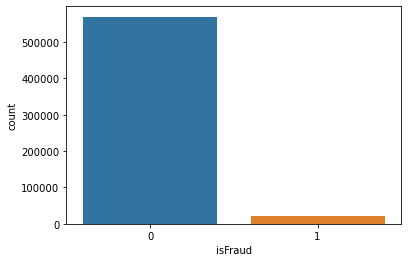

In [96]:
#Plotting the target variable

sns.countplot(x = train_df['isFraud'])
plt.show()

Let's look at this class imbalance in numbers.

In [97]:
train_df['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [98]:
percentage_1 = train_df[train_df['isFraud']==1].shape[0]*100/train_df.shape[0]
print("Percentage of values in the target variable that are one: " + str(round(percentage_1, 3)) + "%")

Percentage of values in the target variable that are one: 3.499%


There's a huge class imbalance in this variable. This will have to be accounted for while building models.

#### Let's look at the TransactionDT column

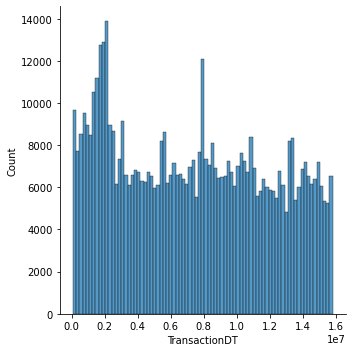

In [99]:
sns.displot(train_df['TransactionDT'])
plt.show()

Since this column is the timedelta from a given reference datetime, and it is given in seconds, we can convert the seconds to days and hours.

In [100]:
train_df['TransactionDT'][150000]

3093457.0

In [101]:
#Creating a new column for transaction day

train_df['TransactionDay'] = (train_df['TransactionDT']//(24*60*60))%7

In [102]:
#Specifying a lambda function to use an estimator

percentage = lambda x: float(len(x))/len(train_df['TransactionDay'])*100

In [103]:
#Setting the seaborn color palette

sns.set_palette('Paired')

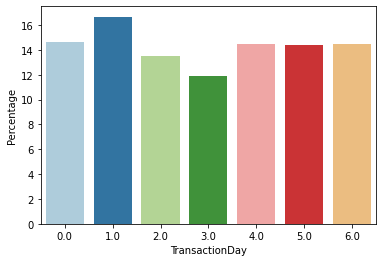

In [104]:
ax = sns.barplot(x = train_df['TransactionDay'], y = train_df['TransactionDay'], estimator = percentage)
ax.set(ylabel='Percentage')
plt.show()

Day 1 has the most transactions, whereas Day 3 has the lowest. This variable needs to be treated as a categorical variable (nominal data).


Let's check the percentage of fraud committed on each day.

In [105]:
#Creating a group by object
train_group_day = train_df.groupby(['isFraud'])

In [106]:
#Normalizing the value counts so that the isFraud=0 values are also visible (the class imbalance makes plots of those values
# very small). Also multiplying by 100, resetting the index, and sorting by the days of the week

train_group_day = train_group_day['TransactionDay'].value_counts(normalize=True).rename('Percentage').mul(100).reset_index().sort_values('TransactionDay')
train_group_day

,isFraud,TransactionDay,Percentage
1,0,0.0,14.593675
8,1,0.0,15.539854
0,0,1.0,16.661841
7,1,1.0,17.180468
5,0,2.0,13.489051
9,1,2.0,14.339641
6,0,3.0,11.883266
13,1,3.0,12.113439
2,0,4.0,14.519975
12,1,4.0,13.003920


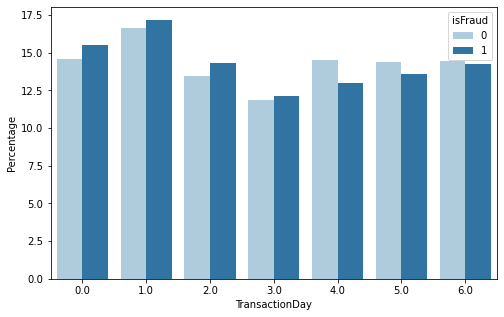

In [107]:
plt.figure(figsize=(8, 5))
sns.barplot(x='TransactionDay', y='Percentage', hue='isFraud', data=train_group_day)
plt.show()

The percentage of fraud committed is relatively higher on days 0 to 3, and lower on the rest of the days.

In [108]:
#Creating a new column for transaction hour

train_df['TransactionHour'] = (train_df['TransactionDT']//(60*60))%24

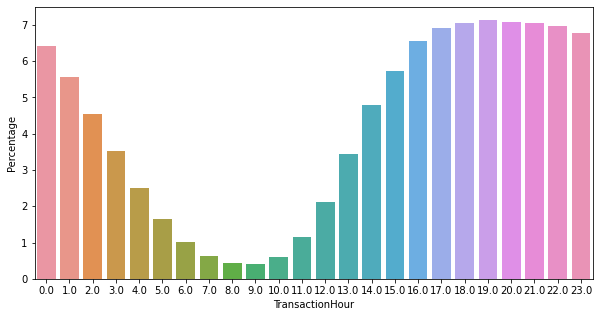

In [109]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = train_df['TransactionHour'], y = train_df['TransactionHour'], estimator = percentage)
ax.set(ylabel='Percentage')
plt.show()

Very few transactions occur between the hours 4 and 12.

In [110]:
#Creating a group by object
train_group_hour = train_df.groupby(['isFraud'])

In [111]:
#Similar operations as before

train_group_hour = train_group_hour['TransactionHour'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index().sort_values('TransactionHour')
train_group_hour

,isFraud,TransactionHour,Percentage
8,0,0.0,6.424018
31,1,0.0,5.739728
33,1,1.0,4.970237
10,0,1.0,5.574887
34,1,2.0,4.849247
12,0,2.0,4.515009
13,0,3.0,3.510407
36,1,3.0,3.857136
15,0,4.0,2.468778
37,1,4.0,3.726468


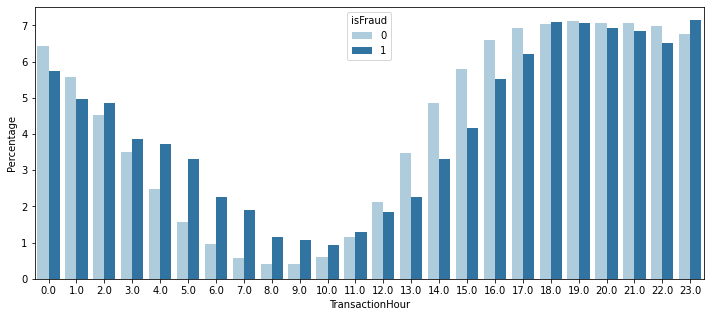

In [112]:
plt.figure(figsize=(12, 5))
sns.barplot(x='TransactionHour', y='Percentage', hue='isFraud', data=train_group_hour)
plt.show()

In [113]:
#We can drop the 'TransactionDT' column as it's no longer required

train_df = train_df.drop(['TransactionDT'], axis=1)

Let's create a new column that categorizes the transaction hour as high, medium, or low risk.

In [114]:
def TransactionHour_Risk_Categorizer(hour):
    if (hour >= 4 and hour <=9):
        return "low"
    elif (hour >= 12 and hour <= 17) or (hour == 0 or hour == 1 or hour == 22):
        return "high"
    else:
        return "medium"

In [115]:
train_df['TransactionHour_Risk'] = train_df['TransactionHour'].apply(TransactionHour_Risk_Categorizer)
train_df['TransactionHour_Risk'].value_counts()

high      286105
medium    265114
low        39321
Name: TransactionHour_Risk, dtype: int64

In [116]:
#We can drop the 'TransactionHour' column as it's no longer required

train_df = train_df.drop(['TransactionHour'], axis=1)

In [117]:
#Adding the two new columns to the list of categorical columns (they should be treated as categorical columns)

categorical_columns.append('TransactionDay')
categorical_columns.append('TransactionHour_Risk')
categorical_columns

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'TransactionDay',
 'TransactionHour_Risk']

In [118]:
#Deleting variables that are no longer required

del train_group_hour, train_group_day

In [119]:
#Triggering garbage collection

gc.collect()

20779

#### Repeating the steps related to the TransactionDT column in the test set

In [120]:
#Creating a new column for transaction day

test_df['TransactionDay'] = (test_df['TransactionDT']//(24*60*60))%7

In [121]:
#Creating a new column for transaction hour

test_df['TransactionHour'] = (test_df['TransactionDT']//(60*60))%24

In [122]:
#We can drop the 'TransactionDT' column as it's no longer required

test_df = test_df.drop(['TransactionDT'], axis=1)

In [123]:
#Creating a new column that categorizes the transaction hour as high, medium, or low risk
test_df['TransactionHour_Risk'] = test_df['TransactionHour'].apply(TransactionHour_Risk_Categorizer)
test_df['TransactionHour_Risk'].value_counts()

high      248718
medium    225234
low        32739
Name: TransactionHour_Risk, dtype: int64

In [124]:
#We can drop the 'TransactionHour' column as it's no longer required

test_df = test_df.drop(['TransactionHour'], axis=1)

#### Let's look at the TransactionAMT column

In [125]:
train_df['TransactionAmt'].describe()

count    590540.000000
mean               NaN
std                NaN
min           0.250977
25%          43.312500
50%          68.750000
75%         125.000000
max       31936.000000
Name: TransactionAmt, dtype: float64

There's a big jump from the 75th percentile to the max value. Let's take a closer look.

In [126]:
print("95 percentile: {} \n99 percentile: {} \n99.5 percentile: {} \n99.9 percentile: {:,.2f}" .format(
    train_df['TransactionAmt'].quantile(0.95), train_df['TransactionAmt'].quantile(0.99), 
    train_df['TransactionAmt'].quantile(0.995), train_df['TransactionAmt'].quantile(0.999)))

95 percentile: 445.0 
99 percentile: 1104.0 
99.5 percentile: 1656.0 
99.9 percentile: 2,768.92


Since the values of the 99.9 percentile indicate that there are outliers in this column, let's check for outliers in the other variables too.

### i. Outlier Treatment

In [127]:
#Adding percentiles to the describe() function

train_df.describe(percentiles=[.25, .5, .75, .95, .99, .995, .999, .9995])

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,TransactionDay
count,590540.000000,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.00000,590540.0,590540.0,590540.000000,590540.000,590540.0,590540.000,590540.000,590540.0,590540.0,590540.0,590540.000,590540.000,590540.0,590540.000,590540.0,590540.0000,590540.0000,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.000000,590540.0,590540.0,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.00000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.00000,590540.00000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0000,590540.000000,590540.000000,590540.00000,590540.0,590540.000000,590540.000000,590540.000000,590540.0000,590540.0000,590540.0000,590540.000000,590540.0,590540.0000,590540.0000,590540.0000,590540.0000,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.000000,590540.000000,590540.000000,590540.00000,590540.0,590540.000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0000,590540.0000,590540.000000,590540.0,590540.0,590540.000000,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0000,590540.0000,590540.0000,590540.0,590540.000000,590540.0,590540.0,590540.000000,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.000000,590540.000000,590540.000000,590540.000,590540.0000,590540.0,590540.000,590540.000,590540.000,590540.0000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,0.034990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000719,0.000868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061890,NaN,NaN,NaN,NaN,NaN,0.085266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.907104,336.360809,203.968872,NaN,NaN,NaN,103.457741,204.777252,145.893814,17.241449,38.800365,26.351665,NaN,NaN,0.087524,NaN,NaN,0.088745,NaN,0.031494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.089111,NaN,NaN,0.045380,0.051880,NaN,NaN,NaN,NaN,139.740570,408.571075,230.384476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.815689,247.595306,162.147934,18.372580,42.072994,28.326597,2.957940
std,0.183755,NaN,NaN,NaN,0.0,0.0,NaN,0.00000,NaN,NaN,0.150635,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0

From the percentile values, it looks like capping these columns at 99.5% will not be enough (I tried dropping all rows where one of the columns was 99.95% or higher, and this removed more than 50% of the rows). 

Let's look at the distributions of some of the columns with outliers.

In [128]:
#Setting the seaborn color palette to default

sns.set()

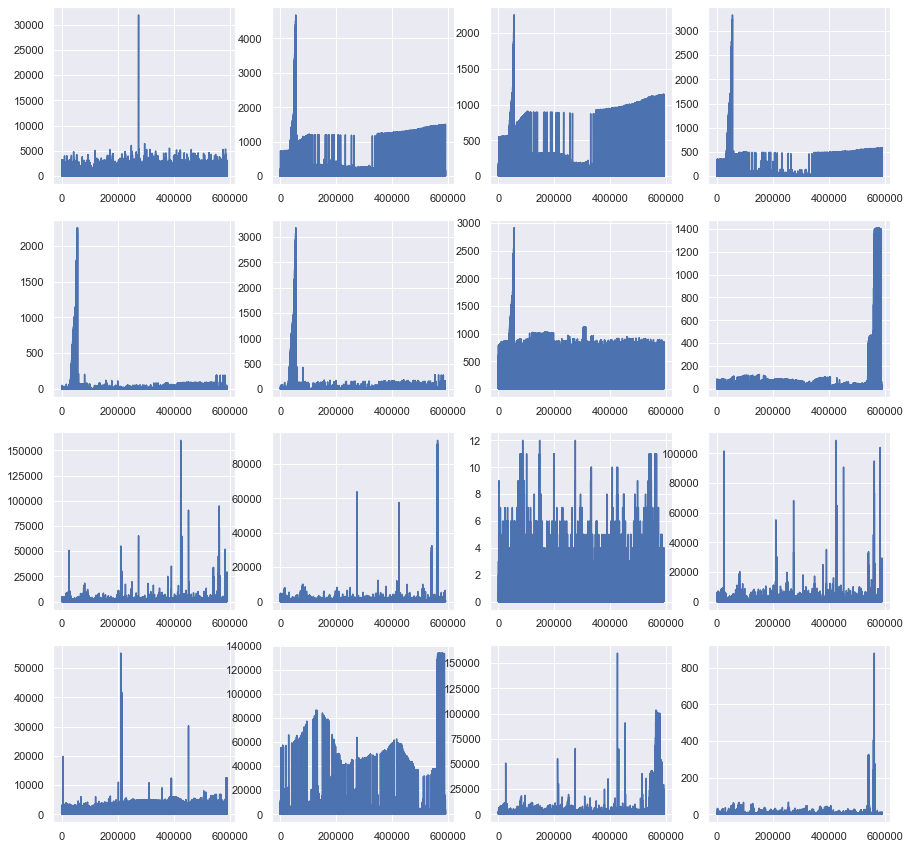

In [129]:
fig, a =  plt.subplots(4,4, figsize=(15,15))

a[0][0].plot(train_df.index, train_df['TransactionAmt'])
a[0][1].plot(train_df.index, train_df['C1'])
a[0][2].plot(train_df.index, train_df['C6'])
a[0][3].plot(train_df.index, train_df['C8'])

a[1][0].plot(train_df.index, train_df['C7'])
a[1][1].plot(train_df.index, train_df['C12'])
a[1][2].plot(train_df.index, train_df['C13'])
a[1][3].plot(train_df.index, train_df['V96'])

a[2][0].plot(train_df.index, train_df['V126'])
a[2][1].plot(train_df.index, train_df['V132'])
a[2][2].plot(train_df.index, train_df['V297'])
a[2][3].plot(train_df.index, train_df['V306'])

a[3][0].plot(train_df.index, train_df['V310'])
a[3][1].plot(train_df.index, train_df['V317'])
a[3][2].plot(train_df.index, train_df['V128'])
a[3][3].plot(train_df.index, train_df['V279'])


plt.show()

These variables are skewed and/or have tall spikes in between. Applying a transformation will be better.

In [130]:
#Creating a backup of the dataframe

train_df_backup = train_df.copy()

In [131]:
#Triggering garbage collection

gc.collect()

60

### Outlier treatment - log transformation

In [132]:
#Creating a list of columns that are to be transformed

cols_transform = ['TransactionAmt', 'card1', 'C1', 'C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14', 
                    'V95', 'V96', 'V97', 'V101', 'V102', 'V103', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 
                    'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V291', 'V292', 'V293', 'V294', 'V295', 'V306', 
                    'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 
                    'V320', 'V321']

In [133]:
#Creating a function to check if there are columns that do not contain any zeros 

def check_col_zeros(df):
    for col in df.columns:
        cols_non_zero = []
        if not (df[col]==0).any():
            cols_non_zero.append(str(col))
    return cols_non_zero          
    

In [134]:
#Checking if the columns that we want to transform contain zero values

cols_log_transform = check_col_zeros(train_df[cols_transform])
len(cols_log_transform)

0

Since all of these columns contain zero values, we cannot use a log transformation directly (as we'll get negative infinity wherever there's a zero). Let's add a constant value before we apply the log function.

In [135]:
#Defining a function to apply log transformation

def log_transform(df, cols_to_transform):
    for col in df.columns:
        if col in cols_to_transform:
            df[col] = np.log(df[col]+1)                #This is to ensure that we don't get -ve inf values
    return df

In [136]:
train_df = log_transform(train_df, cols_transform)

In [137]:
#Let's look at the distribution of variables again

train_df.describe(percentiles=[.25, .5, .75, .95, .99, .995, .999, .9995])

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,TransactionDay
count,590540.000000,590540.000000,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.00000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.0000,590540.0000,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.000000,590540.0,590540.0,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.00000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.00000,590540.00000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0000,590540.000000,590540.000000,590540.00000,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.0000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.0,590540.000000,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.0,590540.0,590540.000000,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,0.034990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000719,0.000868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061890,NaN,NaN,0.064575,NaN,0.088745,0.085266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.673587,1.989002,1.159777,NaN,NaN,NaN,0.297653,0.502768,0.384389,0.228320,0.367637,0.278097,NaN,NaN,0.087524,NaN,NaN,0.088745,NaN,0.031494,NaN,NaN,NaN,NaN,NaN,NaN,0.084595,NaN,NaN,NaN,0.089111,NaN,NaN,0.045380,0.051880,NaN,NaN,NaN,NaN,0.823588,2.442634,1.427383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.381868,0.656786,0.498704,0.237075,0.410173,0.300837,2.957940
std,0.183755,0.000000,0.000000,NaN,0.0,0.0,NaN,0.00000,0.000000,0.000000,

The distribution looks much better. Also, we've got zeros instead of -inf as we've used log(x+1).

Let's look at some of the transformed columns.

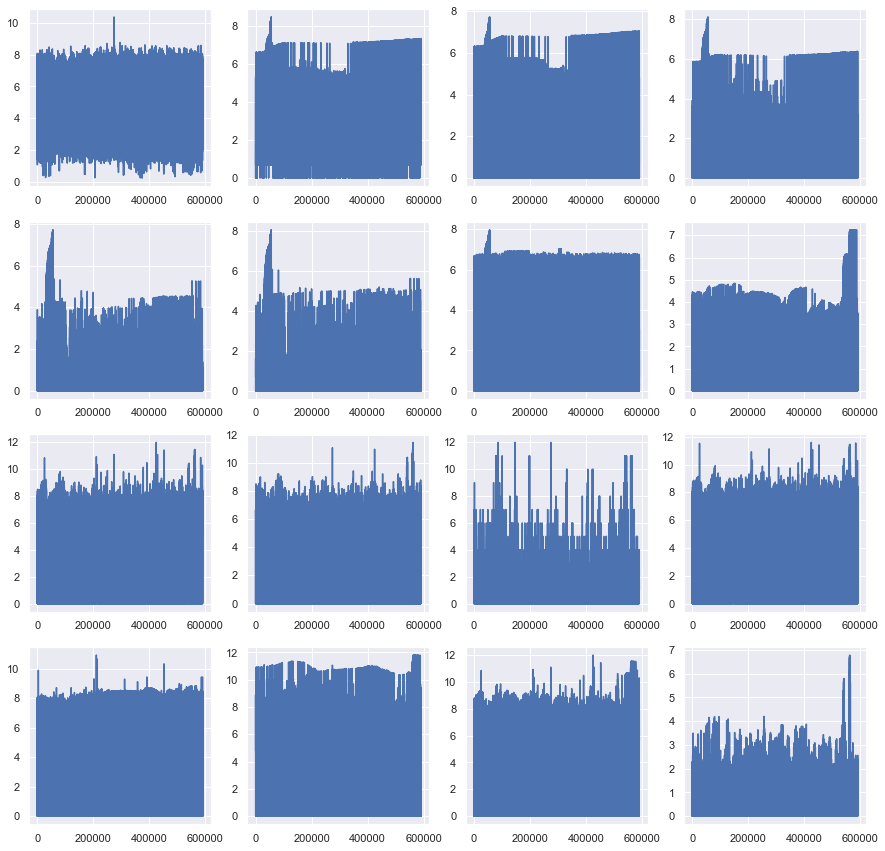

In [138]:
fig, a =  plt.subplots(4,4, figsize=(15,15))

a[0][0].plot(train_df.index, train_df['TransactionAmt'])
a[0][1].plot(train_df.index, train_df['C1'])
a[0][2].plot(train_df.index, train_df['C6'])
a[0][3].plot(train_df.index, train_df['C8'])

a[1][0].plot(train_df.index, train_df['C7'])
a[1][1].plot(train_df.index, train_df['C12'])
a[1][2].plot(train_df.index, train_df['C13'])
a[1][3].plot(train_df.index, train_df['V96'])

a[2][0].plot(train_df.index, train_df['V126'])
a[2][1].plot(train_df.index, train_df['V132'])
a[2][2].plot(train_df.index, train_df['V297'])
a[2][3].plot(train_df.index, train_df['V306'])

a[3][0].plot(train_df.index, train_df['V310'])
a[3][1].plot(train_df.index, train_df['V317'])
a[3][2].plot(train_df.index, train_df['V128'])
a[3][3].plot(train_df.index, train_df['V279'])


plt.show()

Most of the variables' distributions are better. Some of them still have spikes, but the difference in value between the spike and the trough is acceptable.

In [139]:
#Deleting some variables that we no longer need

del cols_log_transform

In [140]:
#Triggering garbage collection

gc.collect()

37833

#### Repeating these steps for the test set

In [141]:
#Performing log transformation

test_df = log_transform(test_df, cols_transform)

#### Getting back to data exploration

Let's visualize the initial few variables: TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, and P_emaildomain.

In [142]:
#To visualize the ProductCD column, we need to use groupby (since we want the 0 and 1 values to be comparable)

ProductCD_group = (train_df.groupby(['isFraud'])['ProductCD'].value_counts(normalize=True).mul(100).rename('Percentage')
                            .reset_index().sort_values('ProductCD'))

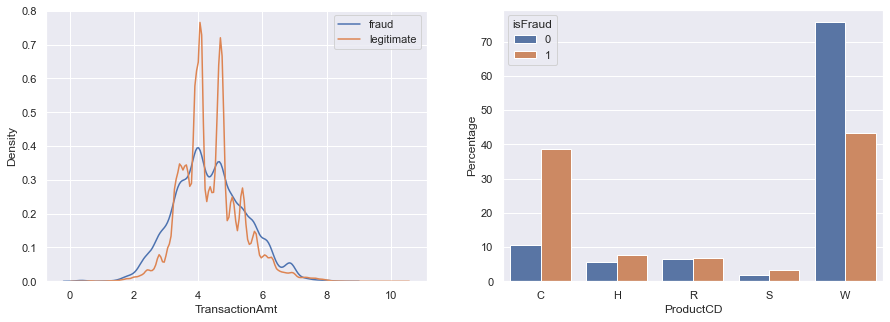

In [143]:
#Plotting the two variables
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_df[train_df['isFraud']==1]['TransactionAmt'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['TransactionAmt'], hist=False)
plt.legend(['fraud','legitimate'])

plt.subplot(1,2,2)
sns.barplot(x="ProductCD", y="Percentage", hue="isFraud", data=ProductCD_group)

plt.show()

In the TransactionAmt variable, the fraudulent transactions have a wider spread, and the legitimate transactions are more likely to be closer to the mid-value.

The ProductCD graph shows that the highest percentage of fraudulent transactions occur for product type 'C'.

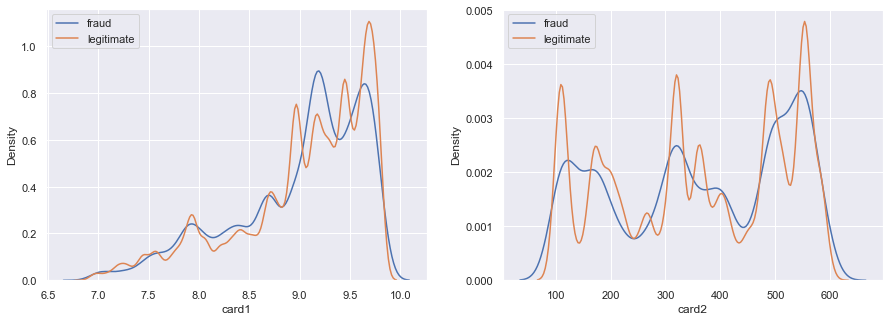

In [144]:
#Plotting the variables card1 and card2
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_df[train_df['isFraud']==1]['card1'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['card1'], hist=False)
plt.legend(['fraud','legitimate'])

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['isFraud']==1]['card2'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['card2'], hist=False)
plt.legend(['fraud','legitimate'])

plt.show()

card1 is skewed even after the log transformation. Both variables show a similar spread for fraudulent and legitimate transactions.

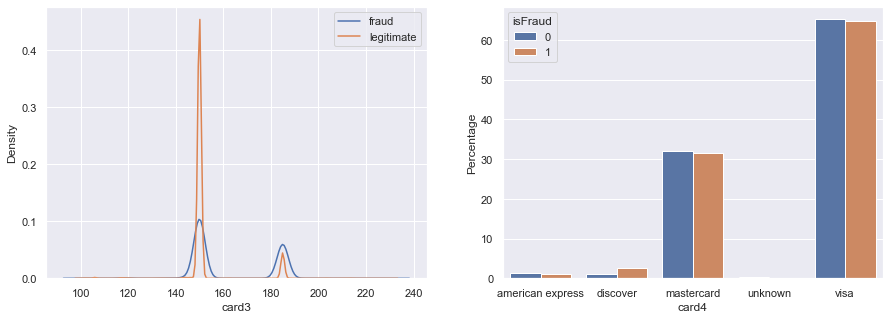

In [145]:
#Plotting the variables card3 and card4
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_df[train_df['isFraud']==1]['card3'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['card3'], hist=False)
plt.legend(['fraud','legitimate'])

plt.subplot(1,2,2)
card4_group = (train_df.groupby(['isFraud'])['card4'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()
                        .sort_values('card4'))
sns.barplot(x="card4", y="Percentage", hue="isFraud", data=card4_group)

plt.show()

card3 shows that the likelihood of fraudulent transactions increases with its value. card4 shows a fairly even percentage of fraudulent and legitimate transactions.

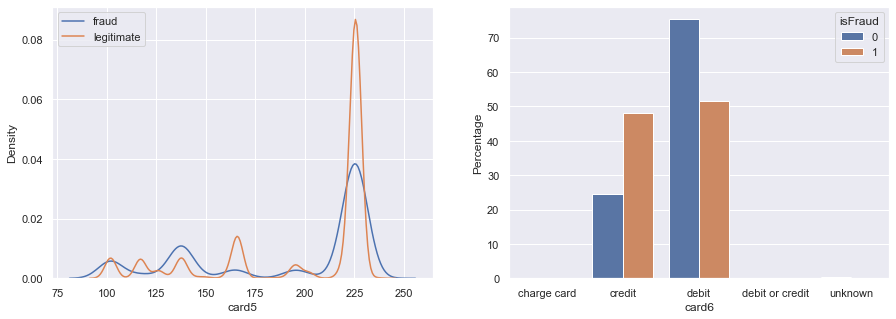

In [146]:
#Plotting the variables card5 and card6
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_df[train_df['isFraud']==1]['card5'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['card5'], hist=False)
plt.legend(['fraud','legitimate'])

plt.subplot(1,2,2)
card6_group = (train_df.groupby(['isFraud'])['card6'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()
                        .sort_values('card6'))
sns.barplot(x="card6", y="Percentage", hue="isFraud", data=card6_group)

plt.show()

card5 shows that legitimate transactions are more likely for higher values of this variable. We can also see that credit card transactions are more likely to be fraudulent than debit card transactions.

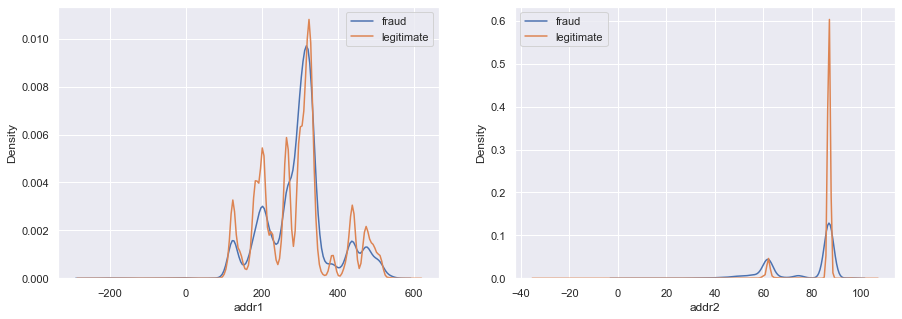

In [147]:
#Plotting the variables addr1 and addr2
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_df[train_df['isFraud']==1]['addr1'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['addr1'], hist=False)
plt.legend(['fraud','legitimate'])

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['isFraud']==1]['addr2'], hist=False)
sns.distplot(train_df[train_df['isFraud']==0]['addr2'], hist=False)
plt.legend(['fraud','legitimate'])

plt.show()

addr1 and addr2 show similar distributions for legit and fraud transactions.

In [148]:
#Checking the number of categories in the p_emaildomain column
print("Number of unique values in the column: {}" .format(len(train_df['P_emaildomain'].unique())))
train_df['P_emaildomain'].value_counts()

Number of unique values in the column: 60


gmail.com           228355
yahoo.com           100934
unknown              94456
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
t

Categories such as yahoo.com.mx and ymail can be merged with the category yahoo.

#### Merging categories in P_emaildomain column

In [149]:
# This method takes a very long time. It's easier to extract the column, perform operations, and insert the column back.
# Leaving this code here to show how to apply a lambda function row-wise

# #Let's discard all characters from the first '.' to the end of the string in the email domains

# email_domain_col = train_df.apply(lambda row: re.sub("\..*$", '', str(row['P_emaildomain'])), axis=1)   #The str() is needed
# #as there are null values in the column and they throw errors when used as a regex pattern
# email_domain_col[:25]


In [150]:
#Making a copy of the P_emaildomain column, as its faster to make changes to the copy and insert it back in the dataframe

email_domain_col = list(train_df['P_emaildomain'])
print("Number of elements in the copied list: {}".format(len(email_domain_col)))
email_domain_col[:5]

Number of elements in the copied list: 590540


['unknown', 'gmail.com', 'outlook.com', 'yahoo.com', 'gmail.com']

In [151]:
#Discarding all characters from the first '.' to the end of the string in the email domains

email_domain_col = [re.sub("\..*$", '', str(i)) for i in email_domain_col]           #The str(i) is needed as there are null 
#characters in the column that throw an error when used for pattern matching in regex

#Also replacing 'ymail' with 'yahoo'
email_domain_col = ['yahoo' if i == 'ymail' else i for i in email_domain_col]

In [152]:
email_domain_col[:15]

['unknown',
 'gmail',
 'outlook',
 'yahoo',
 'gmail',
 'gmail',
 'yahoo',
 'mail',
 'anonymous',
 'yahoo',
 'gmail',
 'hotmail',
 'verizon',
 'aol',
 'yahoo']

In [153]:
#Deleting the old backup dataframe

del train_df_backup

In [154]:
#Making a new backup of the dataframe
train_df_backup_2 = train_df.copy()

In [155]:
train_df['P_emaildomain'] = email_domain_col
train_df.head(15)

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,TransactionDay,TransactionHour_Risk
0,0,4.242188,W,9.539062,361.0,150.0,discover,142.0,credit,315.0,87.00000,unknown,0.693359,0.693359,0.0,0.000000,0.0,0.693359,0.000000,0.000000,1.0,0.000000,1.098633,0.000000,0.693359,0.693359,14.0,13.0000,0.000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693359,0.000000,0.0,0.0,0.0,0.000000,0.693359,0.00000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,4.770685,0.000000,0.0,0.000000,0.000000,0.000000,4.770685,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693359,0.693359,0.000000,0.693359,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,4.770685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.770685,0.000000,0.000000,0.000000,0.000000,1.0,high
1,0,3.400391,W,7.921875,404.0,150.0,mastercard,102.0,credit,325.0,87.00000,gmail,0.693359,0.693359,0.0,0.000000,0.0,0.693359,0.000000,0.000000,0.0,0.000000,0.693359,0.000000,0.693359,0.693359,0.0,0.0000,0.000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693359,0.693359,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,high
2,0,4.093750,W,8.445312,490.0,150.0,visa,166.0,debit,330.0,87.00000,outlook,0.693359,0.693359,0.0,0.000000,0.0,0.693359,0.000000,0.000000,1.0,0.000000,0.693359,0.000000,0.693359,0.693359,0.0,0.0000,315.000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000

In [156]:
#Making a copy of the P_emaildomain column, as its faster to make changes to the copy and insert it back in the dataframe

email_domain_col_test = list(test_df['P_emaildomain'])
print("Number of elements in the copied list: {}".format(len(email_domain_col_test)))
email_domain_col_test[:5]

Number of elements in the copied list: 506691


['gmail.com', 'aol.com', 'hotmail.com', 'gmail.com', 'gmail.com']

In [157]:
#Discarding all characters from the first '.' to the end of the string in the email domains

email_domain_col_test = [re.sub("\..*$", '', str(i)) for i in email_domain_col_test]           #The str(i) is needed as there are null 
#characters in the column that throw an error when used for pattern matching in regex

#Also replacing 'ymail' with 'yahoo'
email_domain_col_test = ['yahoo' if i == 'ymail' else i for i in email_domain_col_test]

In [158]:
print("Number of email domains in the training set {}".format(len(set(email_domain_col))))
print("Number of email domains in the test set {}".format(len(set(email_domain_col_test))))

Number of email domains in the training set 44
Number of email domains in the test set 45


In [159]:
#Checking the email domain that's not present in the training set
set(email_domain_col_test) - set(email_domain_col)

{'scranton'}

In [160]:
#Let's check the number of times the domain name 'scranton' appears in the test set
test_df['P_emaildomain'].value_counts()

gmail.com           207448
yahoo.com            81850
unknown              69192
hotmail.com          40399
anonymous.com        34064
aol.com              24048
comcast.net           6586
icloud.com            6049
outlook.com           4838
att.net               3614
msn.com               3388
sbcglobal.net         2797
live.com              2679
verizon.net           2306
ymail.com             1679
bellsouth.net         1528
yahoo.com.mx          1284
cox.net               1264
me.com                1191
optonline.net          926
live.com.mx            721
charter.net            627
mail.com               597
gmail                  497
earthlink.net          465
rocketmail.com         441
mac.com                426
outlook.es             425
hotmail.fr             379
hotmail.es             322
frontier.com           314
web.de                 278
roadrunner.com         278
juno.com               252
windstream.net         247
hotmail.co.uk          222
twc.com                209
e

In [161]:
#Checking the dimensions of the rows with this domain name
test_df[test_df['P_emaildomain'] == 'scranton.edu'].shape

(2, 182)

In [162]:
#Comparing the dimensions of the train and test sets
print(train_df.shape)
print(test_df.shape)

(590540, 182)
(506691, 182)


The test set contains one column less as it doesn't contain the 'isFraud' column. As a result, we don't know have this information for the rows containing 'scranton.edu' in P_emaildomain. Therefore, let's drop these two rows.

In [163]:
test_df = test_df[test_df['P_emaildomain'] != 'scranton.edu']
test_df.shape

(506689, 182)

In [164]:
#Removing this domain name from the list email_domain_col_test

print("Length of list before the remove function: {}".format(len(email_domain_col_test)))
email_domain_col_test.remove('scranton')
email_domain_col_test.remove('scranton')                    #Running this code twice as there are two rows with this value
print("Length of list after the remove function: {}".format(len(email_domain_col_test)))

Length of list before the remove function: 506691
Length of list after the remove function: 506689


In [165]:
#Inserting the merged domain names back to the dataframe
test_df['P_emaildomain'] = email_domain_col_test

Note: This is an advantage of performing operations on the test set alongside the train set. If this category had been discovered later by label encoder, it would not have been able to handle it.

In [166]:
#Deleting variables that are no longer required

del email_domain_col, email_domain_col_test

In [167]:
#Triggering garbage collection

gc.collect()

34124

In [168]:
#Checking the number of unique values in the P_emaildomain column
len(train_df['P_emaildomain'].unique())

44

The number of categories has been reduced from 60 to 44.

#### Visualizing the P_emaildomain column

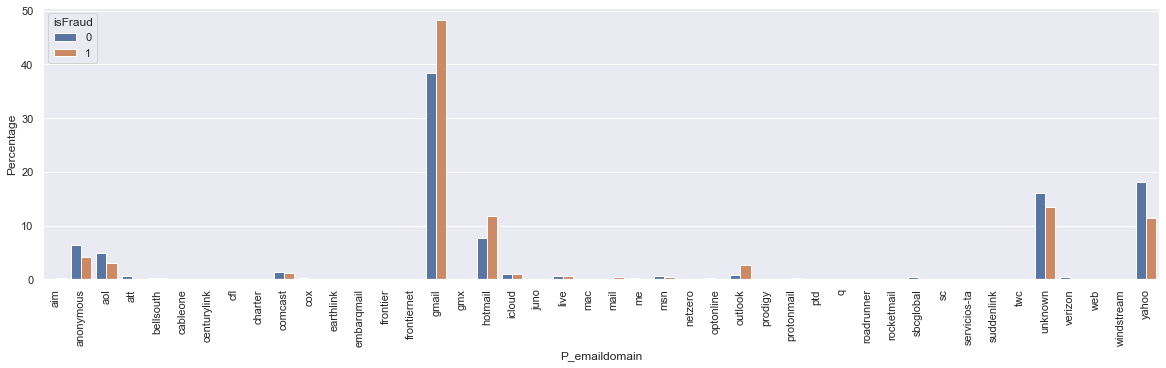

In [169]:
plt.figure(figsize=(20,5))

Email_group = (train_df.groupby(['isFraud'])['P_emaildomain'].value_counts(normalize=True).mul(100).rename('Percentage')
                       .reset_index().sort_values('P_emaildomain'))
sns.barplot(x="P_emaildomain", y="Percentage", hue="isFraud", data=Email_group)
plt.xticks(rotation=90)

plt.show()

Two of the most frequently used email domains - gmail and hotmail have a high percentage of fraud when compared to the others.

## Data Preparation for Modelling

In [170]:
#Let's look at the data types of all the columns

train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 182 columns):
 #   Column                Dtype  
---  ------                -----  
 0   isFraud               int8   
 1   TransactionAmt        float16
 2   ProductCD             object 
 3   card1                 float16
 4   card2                 float16
 5   card3                 float16
 6   card4                 object 
 7   card5                 float16
 8   card6                 object 
 9   addr1                 float16
 10  addr2                 float16
 11  P_emaildomain         object 
 12  C1                    float16
 13  C2                    float16
 14  C3                    float16
 15  C4                    float16
 16  C5                    float16
 17  C6                    float16
 18  C7                    float16
 19  C8                    float16
 20  C9                    float16
 21  C10                   float16
 22  C11                   float16
 23  C12     

In [171]:
train_df.head(10)

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,TransactionDay,TransactionHour_Risk
0,0,4.242188,W,9.539062,361.0,150.0,discover,142.0,credit,315.0,87.0,unknown,0.693359,0.693359,0.0,0.0,0.0,0.693359,0.0,0.000000,1.0,0.000000,1.098633,0.0,0.693359,0.693359,14.0,13.0000,0.000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693359,0.000000,0.0,0.0,0.0,0.000000,0.693359,0.00000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,4.770685,0.000000,0.0,0.000000,0.000000,0.000000,4.770685,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693359,0.693359,0.000000,0.693359,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,4.770685,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,4.770685,0.000000,0.0,0.0,0.0,1.0,high
1,0,3.400391,W,7.921875,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail,0.693359,0.693359,0.0,0.0,0.0,0.693359,0.0,0.000000,0.0,0.000000,0.693359,0.0,0.693359,0.693359,0.0,0.0000,0.000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693359,0.693359,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,high
2,0,4.093750,W,8.445312,490.0,150.0,visa,166.0,debit,330.0,87.0,outlook,0.693359,0.693359,0.0,0.0,0.0,0.693359,0.0,0.000000,1.0,0.000000,0.693359,0.0,0.693359,0.693359,0.0,0.0000,315.000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [172]:
categorical_columns

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'TransactionDay',
 'TransactionHour_Risk']

In [173]:
#Let's take a look at the values of the categorical columns

for i in categorical_columns:
    print(train_df[i].value_counts())
    print("\n")

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64


visa                384767
mastercard          189217
american express      8328
discover              6651
unknown               1577
Name: card4, dtype: int64


debit              439938
credit             148986
unknown              1571
debit or credit        30
charge card            15
Name: card6, dtype: int64


gmail           228851
yahoo           105305
unknown          94456
hotmail          46005
anonymous        36998
aol              28289
comcast           7888
icloud            6267
outlook           5534
msn               4092
att               4033
live              3846
sbcglobal         2970
verizon           2705
bellsouth         1909
me                1522
cox               1393
optonline         1011
charter            816
rocketmail         664
mail               559
earthlink          514
mac                436
netzero            426
juno               322
aim         

Let's use label encoding for the P_emaildomain column, as LGBM requires integers in categorical columns (so we cannot frequency encoding).

### Using label encoding for categorical variables

Since LGBM requires non-negative integers in its categorical columns, let's use label encoding for all these columns

In [174]:
d = defaultdict(LabelEncoder)

train_df[categorical_columns] = train_df[categorical_columns].apply(lambda x: d[x.name].fit_transform(x))

In [175]:
train_df.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,TransactionDay,TransactionHour_Risk
0,0,4.242188,4,9.539062,361.0,150.0,1,142.0,1,315.0,87.0,39,0.693359,0.693359,0.0,0.0,0.0,0.693359,0.0,0.000000,1.0,0.000000,1.098633,0.0,0.693359,0.693359,14.0,13.0000,0.000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,1.000000,1.000000,1.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693359,0.000000,0.0,0.0,0.0,0.000000,0.693359,0.00000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,4.770685,0.000000,0.0,0.000000,0.000000,0.000000,4.770685,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693359,0.693359,0.000000,0.693359,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,4.770685,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,4.770685,0.000000,0.0,0.0,0.0,1,0
1,0,3.400391,4,7.921875,404.0,150.0,2,102.0,1,325.0,87.0,15,0.693359,0.693359,0.0,0.0,0.0,0.693359,0.0,0.000000,0.0,0.000000,0.693359,0.0,0.693359,0.693359,0.0,0.0000,0.000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0000,0.000000,1.000000,1.000000,1.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.693359,0.693359,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1,0
2,0,4.093750,4,8.445312,490.0,150.0,4,166.0,2,330.0,87.0,27,0.693359,0.693359,0.0,0.0,0.0,0.693359,0.0,0.000000,1.0,0.000000,0.693359,0.0,0.693359,0.693359,0.0,0.0000,315.000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.00000

In [176]:
#Encoding the same columns in the test set
test_df[categorical_columns] = test_df[categorical_columns].apply(lambda x: d[x.name].transform(x))

In [177]:
test_df.head()

,V84,V65,V283,V85,V72,D15,V32,V309,V55,C8,V321,card3,V15,V134,V25,V54,V115,V311,V288,V12,V121,V87,V64,V132,V98,V123,card6,C9,V76,V60,V117,V99,C5,V91,V113,V306,V294,V22,V31,V77,V106,V137,V82,V116,V285,card5,V112,V94,V53,C7,V305,V74,V130,V69,V109,V61,V20,V18,V317,V73,V296,V28,card2,V105,V128,C6,V302,V316,V293,V303,C14,V280,V21,V26,V281,V136,V315,V295,V124,V287,V129,V125,V318,V66,V299,V33,V29,V290,V118,V314,V304,V19,V71,V320,V279,V88,C10,V110,V97,V300,V111,addr2,V119,C11,V16,V135,V122,addr1,card4,V133,C1,V56,V102,V286,V108,V291,V24,V34,C2,V282,V319,TransactionID,V13,V297,P_emaildomain,D10,V70,V23,V30,C13,V68,TransactionAmt,card1,V27,V127,V284,V114,V308,V86,V83,V57,C3,V17,V312,V289,V78,V14,V62,C4,V63,V89,V96,V90,V58,V92,V100,V93,V95,V301,V298,V104,V79,V59,V103,V107,V67,V80,V131,C12,V120,V313,V81,V310,V101,ProductCD,D1,V307,V75,V292,V126,TransactionDay,TransactionHour_Risk
0,0.0,1.0,0.0,0.0,0.0,409.0,0.0,0.000000,1.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2,6.0,0.0,0.0,1.0,1.0,3.0,1.0,1.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,226.0,1.0,0.0,0.0,0.0,1.0,0.0,3.890799,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.0,0.0,0.000000,1.609375,0.0,0.0,0.0,0.0,1.946289,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,1.0,0.000000,0.0,1.0,87.0,1.0,1.791992,0.0,0.0,1.0,170.0,4,0.0,1.946289,1.0,0.0,0.0,1.0,0.693359,1.0,0.0,1.946289,0.0,0.0,3663549,0.0,0.0,15,418.0,0.0,1.0,0.0,4.753906,0.0,3.494141,9.250000,0.0,3.890799,0.0,1.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.693359,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.693359,1.0,0.000000,0.0,3.890799,0.0,4,419.0,3.890799,0.0,0.693359,0.000000,3,0
1,0.0,1.0,0.0,0.0,0.0,634.0,0.0,0.000000,1.0,0.0,0.0,150.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2,2.0,1.0,0.0,1.0,4.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,4.0,226.0,1.0,0.0,0.0,0.0,1.0,0.0,5.638355,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,111.0,0.0,4.356709,0.693359,0.0,0.0,0.0,0.0,1.098633,0.693359,0.0,1.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.0,1.0,0.0,0.000000,0.000000,1.0,0.0,1.0,0.693359,0.0,1.0,87.0,1.0,0.693359,0.0,0.0,1.0,299.0,4,0.0,1.386719,1.0,0.0,0.0,1.0,0.693359,1.0,0.0,1.098633,0.0,0.0,3663550,1.0,0.0,2,231.0,0.0,1.0,0.0,2.564453,0.0,3.912109,8.359375,0.0,5.638355,0.0,1.0,4.356709,1.0,1.0,0.0,0.0,0.0,4.356709,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.609375,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.356709,0.693359,1.0,0.000000,0.0,5.638355,0.0,4,149.0,5.638355,1.0,0.693359,0.000000,3,0
2,0.0,1.0,0.0,0.0,0.0,97.0,0.0,0.000000,1.0,0.0,0.0,150.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2,4.0,2.0,0.0,1.0,3.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,4.0,226.0,1.0,0.0,0.0,0.0,1.0,0.0,6.559615,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,574.0,2.0,0.000000,1.791992,0.0,0.0,0.0,0.0,1.098633,0.000000,0.0,1.0,0.0,5.575949,0.000000,0.0,1.0,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.0,1.0,0.0,5.575949,0.000000,1.0,0.0,1.0,0.000000,0.0,1.0,87.0,1.0,1.098633,0.0,0.0,1.0,472.0,4,0.0,1.098633,1.0,0.0,0.0,1.0,1.098633,2.0,0.0,1.098633,0.0,0.0,3663551,1.0,0.0,17,136.0,0.0,2.0,0.0,3.134766,0.0,5.148438,8.406250,0.0,6.876265,0.0,1.0,0.000000,1.0,2.0,0.0,0.0,0.0,0.000000,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.791992,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.000000,1.0,0.000000,0.0,6.965080,0.0,4,137.0,7.186901,1.0,0.693359,0.000000,3,0
3,0.0,1.0,1.0,0.0,0.0,242.0,0.0,0.000000,1.0,0.0,0.0,150.0,0.0,0.0,1.0,1.0,1.0,0.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,166.0,1.0,0.0,1.0,0.0,1.0,0.0,0.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,360.0,0.0,0.000000,0.693359,0.0,0.0,0.0,0.0,1.609375,0.000000,0.0,1.0,0.0,0.000000,5.648438,0.0,1.0,0.0,0.000000,1.0,0.0,1.

### Splitting the dataframe into train and validation sets

In [178]:
#Splitting the data 70-30

X_train, X_val = train_test_split(train_df, train_size = 0.75, test_size = 0.2, random_state = 100)

In [179]:
y_train = X_train['isFraud']
y_val = X_val['isFraud']
X_train = X_train.drop(['isFraud'], axis=1)
X_val = X_val.drop(['isFraud'], axis=1)

In [180]:
print(y_train.shape, type(y_train))
print(y_val.shape, type(y_val))
print(X_train.shape, type(X_train))
print(X_val.shape, type(X_val))

(442905,) <class 'pandas.core.series.Series'>
(118108,) <class 'pandas.core.series.Series'>
(442905, 181) <class 'pandas.core.frame.DataFrame'>
(118108, 181) <class 'pandas.core.frame.DataFrame'>


In [181]:
# y_train = np.array(y_train)           #This is because GridSearch requires X to be a df or a np array, and y must be a numpy array of shape (n,)
# y_val = np.array(y_val)
# print(y_train.shape)

Before we start modelling, let's delete all the variables that are no longer needed.

In [182]:
#Checking the current user-defined variables

%who

DecisionTreeClassifier	 Email_group	 GridSearchCV	 IterativeImputer	 LabelEncoder	 LogisticRegression	 PCA	 Pipeline	 ProductCD_group	 
RandomForestClassifier	 StandardScaler	 StratifiedKFold	 TransactionHour_Risk_Categorizer	 X_train	 X_val	 a	 ax	 card4_group	 
card6_group	 categorical_columns	 check_col_zeros	 col	 cols_to_retain	 cols_transform	 confusion_matrix	 count	 cross_val_score	 
d	 defaultdict	 dropped_columns	 elapsed_time	 ele	 enable_iterative_imputer	 end_time	 fig	 float_int_memory_reducer	 
gc	 i	 imputer	 log_transform	 median_impute_cols	 medians_of_cols	 missing_values_df	 mode_impute_cols	 modes_of_cols	 
non_string_cols	 np	 path	 pd	 percentage	 percentage_1	 plt	 re	 roc_auc_score	 
sns	 start_process_time	 start_time	 test_df	 test_df_imputed	 test_df_not_string	 time	 train_df	 train_df_backup_2	 
train_df_imputed	 train_df_not_string	 train_test_split	 tree	 warnings	 y_train	 y_val	 


In [183]:
#Let's delete all the unnecessary variables

del (Email_group, ProductCD_group, a, ax, card4_group, card6_group, categorical_columns, cols_to_retain, cols_transform, dropped_columns,      
     fig, i, missing_values_df, percentage, percentage_1, train_df_backup_2, TransactionHour_Risk_Categorizer, check_col_zeros, 
     log_transform, median_impute_cols, medians_of_cols, mode_impute_cols, modes_of_cols, non_string_cols, test_df_imputed, test_df_not_string, 
     train_df_imputed, train_df_not_string)

In [184]:
#Triggering garbage collection

gc.collect()

63894

## Modelling

In [185]:
# apply pca to train data
pca_steps = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])

In [186]:
fraud_pca = pca_steps.fit_transform(X_train)

In [187]:
# extract pca model from pipeline
pca_model = pca_steps.named_steps['pca']

# look at explainded variance of PCA components
print(pd.Series(np.round(pca_model.explained_variance_ratio_.cumsum(), 4)*100))

0       17.77
1       30.82
2       35.78
3       40.51
4       44.92
5       48.11
6       51.02
7       53.64
8       55.95
9       58.05
10      60.05
11      61.98
12      63.88
13      65.59
14      67.25
15      68.84
16      70.22
17      71.49
18      72.73
19      73.84
20      74.90
21      75.86
22      76.73
23      77.53
24      78.27
25      78.98
26      79.66
27      80.30
28      80.91
29      81.51
30      82.08
31      82.64
32      83.19
33      83.75
34      84.30
35      84.85
36      85.38
37      85.89
38      86.39
39      86.89
40      87.37
41      87.84
42      88.28
43      88.71
44      89.12
45      89.51
46      89.88
47      90.24
48      90.58
49      90.91
50      91.23
51      91.54
52      91.84
53      92.13
54      92.41
55      92.66
56      92.91
57      93.15
58      93.39
59      93.62
60      93.84
61      94.06
62      94.27
63      94.48
64      94.67
65      94.86
66      95.03
67      95.20
68      95.37
69      95.52
70      95.67
71    

~63% of the variables explain 99% of the variance.

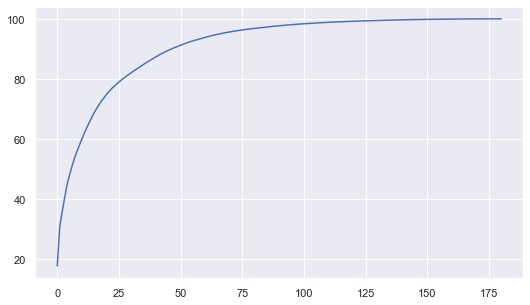

In [188]:
# plot feature variance
features = range(pca_model.n_components_)
cumulative_variance = np.round(np.cumsum(pca_model.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20,100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)

In [189]:
#Checking the class imbalance to adjust class weights
train_df['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [190]:
%who

DecisionTreeClassifier	 GridSearchCV	 IterativeImputer	 LabelEncoder	 LogisticRegression	 PCA	 Pipeline	 RandomForestClassifier	 StandardScaler	 
StratifiedKFold	 X_train	 X_val	 col	 confusion_matrix	 count	 cross_val_score	 cumulative_variance	 d	 
defaultdict	 elapsed_time	 ele	 enable_iterative_imputer	 end_time	 features	 float_int_memory_reducer	 fraud_pca	 gc	 
imputer	 np	 path	 pca_model	 pca_steps	 pd	 plt	 re	 roc_auc_score	 
sns	 start_process_time	 start_time	 test_df	 time	 train_df	 train_test_split	 tree	 warnings	 
y_train	 y_val	 


In [191]:
del IterativeImputer, LabelEncoder, defaultdict, enable_iterative_imputer, fraud_pca, imputer, pca_model, pca_steps, train_test_split, train_df 

In [192]:
gc.collect()

80

In [193]:
#Setting the number of variables for PCA models at 114 (they explain 99% of the variance)
pca_vars = 114
pca_steps = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=pca_vars))])

In [194]:
#Applying PCA to reduce the number of variables
fraud_pca = pca_steps.fit_transform(X_train)
X_train_pca = pd.DataFrame(fraud_pca)
type(X_train_pca)

pandas.core.frame.DataFrame

In [195]:
#Doing the same for the X_val dataframe
X_val_pca = pd.DataFrame(pca_steps.transform(X_val))
type(X_val_pca)

pandas.core.frame.DataFrame

In [196]:
del X_train, X_val

In [197]:
#Reducing the memory used by the train dataset
X_train_pca = float_int_memory_reducer(pd.DataFrame(X_train_pca))

Memory usage decreased to 96.30 Mb (75.0% reduction)


In [198]:
#Reducing the memory used by the validation dataset
X_val_pca = float_int_memory_reducer(pd.DataFrame(X_val_pca))

Memory usage decreased to 25.68 Mb (75.0% reduction)


In [199]:
#Triggering garbage collection

gc.collect()

20

### Model 1: Logistic Regresssion

In [200]:
#Using logistic regression--the class weight is used to handle class imbalance
logistic = LogisticRegression(class_weight={0:0.035, 1: 0.965}, random_state = 100)

#Creating a pipeline (so that we have an unscaled dataframe for tree models)
pipeline_steps = [("scaler", StandardScaler()), ("pca", PCA(n_components=pca_vars)), ("logistic", logistic)]

logistic_pipeline = Pipeline(pipeline_steps)

#hyperparameter space
params = {'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}            #C is sort of like 1/lambda

#create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# create gridsearch object
logistic_gridsearch_model = GridSearchCV(estimator=logistic_pipeline, cv=folds, param_grid=params, 
                                         scoring='roc_auc', verbose=1)

logistic_gridsearch_model.fit(X_train_pca, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  9.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=114)),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.035,
                                                                         1: 0.965},
                                                           random_state=100))]),
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [201]:
#cross validation results
pd.DataFrame(logistic_gridsearch_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.952906,0.026410,0.000000,0.000000,0.1,l1,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
1,8.322200,0.254719,0.263468,0.017291,0.1,l2,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'}",0.853304,0.852416,0.859311,0.854456,0.849788,0.853855,0.003132,8
2,4.979126,0.026027,0.000000,0.000000,0.5,l1,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
3,8.709913,0.208747,0.254565,0.001943,0.5,l2,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'}",0.853336,0.852433,0.859391,0.854486,0.849774,0.853884,0.003162,7
4,5.009885,0.068190,0.000000,0.000000,1,l1,"{'logistic__C': 1, 'logistic__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
5,8.783574,0.235948,0.253185,0.004573,1,l2,"{'logistic__C': 1, 'logistic__penalty': 'l2'}",0.853342,0.852433,0.859406,0.854490,0.849773,0.853889,0.003167,6
6,4.939495,0.055842,0.000000,0.000000,2,l1,"{'logistic__C': 2, 'logistic__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
7,8.609932,0.066856,0.253368,0.003442,2,l2,"{'logistic__C': 2, 'logistic__penalty': 'l2'}",0.853346,0.852430,0.859413,0.854492,0.849772,0.853891,0.003170,5
8,4.967903,0.014847,0.000000,0.000000,3,l1,"{'logistic__C': 3, 'logistic__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
9,8.625421,0.127798,0.265837,0.024007,3,l2,"{'logistic__C': 3, 'logistic__penalty': 'l2'}",0.853348,0.852430,0.859416,0.854493,0.849771,0.853892,0.003171,4


In [202]:
#printing the best hyperparameters
print("Best AUC: ", logistic_gridsearch_model.best_score_)
print("Best hyperparameters: ", logistic_gridsearch_model.best_params_)

Best AUC:  0.8538924264073646
Best hyperparameters:  {'logistic__C': 10, 'logistic__penalty': 'l2'}


Let's make predictions on the validation set using these tuned parameters

In [203]:
# predict fraud on test data
y_pred_log = logistic_gridsearch_model.predict(X_val_pca)

# check area under curve
print("AUC:    \t", round(roc_auc_score(y_val, y_pred_log),2))

AUC:    	 0.78


Let's check if the auc goes up with other models.

### Model 2: Decision Trees

In [204]:
gc.collect()

305

In [205]:
# Create the parameter grid 
param_grid = {
    'max_depth': [8, 10, 12, 14, 16, 18],
    'min_samples_leaf': [10, 20, 40, 80, 160, 240],
    'max_leaf_nodes': [10, 20, 40, 80, 120, 160],
    'criterion': ['entropy', 'gini'],
    'max_features' : ['auto']
}

#Specify the number of folds
n_folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# Instantiate the grid search model
dtree_pca_grid = DecisionTreeClassifier(random_state=100, class_weight='balanced')
dtree_gridsearch_model = GridSearchCV(estimator = dtree_pca_grid, param_grid = param_grid, cv = n_folds, 
                                      verbose = 1, scoring='roc_auc', n_jobs=-1)


# Fit the grid search to the data
dtree_gridsearch_model.fit(X_train_pca, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 28.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=100),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [8, 10, 12, 14, 16, 18],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [10, 20, 40, 80, 120, 160],
                         'min_samples_leaf': [10, 20, 40, 80, 160, 240]},
             scoring='roc_auc', verbose=1)

In [206]:
#cross validation results
pd.DataFrame(dtree_gridsearch_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.250049,0.345217,0.162208,0.040208,entropy,8,auto,10,10,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.777101,0.770136,0.775422,0.767089,0.765539,0.771057,0.004530,361
1,7.173298,0.291520,0.135669,0.037579,entropy,8,auto,10,20,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.777101,0.770136,0.775422,0.767089,0.765539,0.771057,0.004530,361
2,7.302194,0.342195,0.133464,0.022599,entropy,8,auto,10,40,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.777101,0.770136,0.775422,0.767089,0.765539,0.771057,0.004530,361
3,7.135445,0.104402,0.153019,0.033862,entropy,8,auto,10,80,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.777101,0.770136,0.775422,0.767089,0.765539,0.771057,0.004530,361
4,7.056945,0.173179,0.173489,0.041280,entropy,8,auto,10,160,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.777101,0.770136,0.775422,0.767089,0.765539,0.771057,0.004530,361
5,7.212029,0.089896,0.130504,0.024975,entropy,8,auto,10,240,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.777101,0.770136,0.775422,0.767089,0.765539,0.771057,0.004530,361
6,8.808573,0.194090,0.138859,0.027387,entropy,8,auto,20,10,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.793095,0.790875,0.794125,0.789217,0.785742,0.790611,0.002975,319
7,8.293502,0.277066,0.135155,0.033468,entropy,8,auto,20,20,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.793095,0.790875,0.794125,0.789217,0.785742,0.790611,0.002975,319
8,8.141900,0.315684,0.140758,0.017065,entropy,8,auto,20,40,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.793095,0.790875,0.794125,0.789217,0.785742,0.790611,0.002975,319
9,8.228339,0.200508,0.143696,0.031752,entropy,8,auto,20,80,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.793095,0.790875,0.794125,0.789217,0.785742,0.790611,0.002975,319


In [207]:
#printing the best hyperparameters
print("Best AUC: ", dtree_gridsearch_model.best_score_)
print("Best hyperparameters: ", dtree_gridsearch_model.best_params_)

Best AUC:  0.826621693871742
Best hyperparameters:  {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': 160, 'min_samples_leaf': 10}


In [208]:
# predict fraud on test data
y_pred_log = dtree_gridsearch_model.predict(X_val_pca)

# check area under curve
print("AUC:    \t", round(roc_auc_score(y_val, y_pred_log),2))

AUC:    	 0.75


### Model 3: Random Forest

In [209]:
# random forest - the class weight is used to handle class imbalance - it adjusts the cost function
forest_pca_grid = RandomForestClassifier(class_weight={0:0.035, 1: 0.965}, n_jobs = -1)

# hyperparameter space
param_grid = {
    'max_depth': [12, 14, 16, 18],
    'min_samples_leaf': [40, 80, 160, 240],
    'criterion': ['entropy', 'gini'],
    'max_features' : ['auto']
}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
forest_gridsearch_model = GridSearchCV(estimator=forest_pca_grid, cv=folds, param_grid=param_grid, 
                                       scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit the grid search to the data
forest_gridsearch_model.fit(X_train_pca, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 146.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=RandomForestClassifier(class_weight={0: 0.035, 1: 0.965},
                                              n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [12, 14, 16, 18],
                         'max_features': ['auto'],
                         'min_samples_leaf': [40, 80, 160, 240]},
             scoring='roc_auc', verbose=1)

In [210]:
#cross validation results
pd.DataFrame(forest_gridsearch_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,622.859770,1.789499,2.557312,0.726516,entropy,12,auto,40,"{'criterion': 'entropy', 'max_depth': 12, 'max...",0.895425,0.887971,0.887430,0.884616,0.891653,0.889419,0.003747,9
1,625.063016,1.416116,4.392288,3.433036,entropy,12,auto,80,"{'criterion': 'entropy', 'max_depth': 12, 'max...",0.891844,0.885070,0.883789,0.880464,0.889168,0.886067,0.004014,15
2,612.081590,8.379904,4.955266,2.112708,entropy,12,auto,160,"{'criterion': 'entropy', 'max_depth': 12, 'max...",0.887611,0.879746,0.879497,0.875436,0.884833,0.881425,0.004296,23
3,600.061741,7.756390,9.399792,2.063786,entropy,12,auto,240,"{'criterion': 'entropy', 'max_depth': 12, 'max...",0.884741,0.876918,0.876120,0.871965,0.880563,0.878061,0.004316,31
4,685.339630,18.623234,13.730969,4.907649,entropy,14,auto,40,"{'criterion': 'entropy', 'max_depth': 14, 'max...",0.899857,0.891893,0.891703,0.889246,0.896217,0.893783,0.003776,3
5,671.508726,11.077711,9.696409,4.196928,entropy,14,auto,80,"{'criterion': 'entropy', 'max_depth': 14, 'max...",0.895077,0.887765,0.887282,0.884793,0.891995,0.889382,0.003670,10
6,641.385619,12.765743,12.907995,4.866277,entropy,14,auto,160,"{'criterion': 'entropy', 'max_depth': 14, 'max...",0.889374,0.882615,0.881302,0.878941,0.886592,0.883765,0.003745,19
7,625.047698,19.942651,18.145177,1.798284,entropy,14,auto,240,"{'criterion': 'entropy', 'max_depth': 14, 'max...",0.886719,0.879498,0.877399,0.874579,0.881810,0.880001,0.004119,27
8,742.247271,10.658731,12.169934,1.815260,entropy,16,auto,40,"{'criterion': 'entropy', 'max_depth': 16, 'max...",0.900860,0.894257,0.893009,0.891354,0.897724,0.895441,0.003424,1
9,724.281015,9.559699,18.033980,2.569013,entropy,16,auto,80,"{'criterion': 'entropy', 'max_depth': 16, 'max...",0.895614,0.889038,0.886745,0.885834,0.892273,0.889901,0.003619,8


In [211]:
#printing the best hyperparameters
print("Best AUC: ", forest_gridsearch_model.best_score_)
print("Best hyperparameters: ", forest_gridsearch_model.best_params_)

Best AUC:  0.8954405515326223
Best hyperparameters:  {'criterion': 'entropy', 'max_depth': 16, 'max_features': 'auto', 'min_samples_leaf': 40}


In [212]:
# predict fraud on test data
y_pred_log = forest_gridsearch_model.predict(X_val_pca)

# check area under curve
print("AUC:    \t", round(roc_auc_score(y_val, y_pred_log),2))

AUC:    	 0.79


In [216]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [217]:
import lightgbm as lgb

In [218]:
#Using the tuned hyperparameters for fitting the model

params_1 = { 'num_leaves': 224,
           'max_depth' : 16,
           'max_bin': 255,
           'feature_fraction' : 0.8,
           'bagging_fraction' : 0.5,
           'lambda_l1': 0.25,
           'lambda_l2': 0,
           'random_state' : 100, 
           'bagging_seed' : 100,              
           'objective' : 'binary',             
           'boosting_type' : 'gbdt',           
           'metric' : 'auc',                   
           'is_unbalance' : True,              
           'n_jobs' : -1,                   
           'num_iterations' : 100                   
         }


#Creating datasets for fitting this model (as some parameters cannot be changed after constructing a dataset)
d_train = lgb.Dataset(X_train_pca, y_train)


model_tuned_1 = lgb.train(params_1, d_train, verbose_eval=50)

[LightGBM] [Info] Number of positive: 15564, number of negative: 427341
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29070
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035141 -> initscore=-3.312622
[LightGBM] [Info] Start training from score -3.312622


In [219]:
# predict fraud on test data
y_pred_log = model_tuned_1.predict(X_val_pca)

# check area under curve
print("AUC:    \t", round(roc_auc_score(y_val, y_pred_log),2))

AUC:    	 0.91
